In [2]:
import sys
sys.path.append('..')
%load_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import corner
from matplotlib import pyplot as plt
from copy import copy
from astropy.io import fits
from sprinkler import BaseSprinkler, OM10Reader, GoldsteinSNeCatReader, DC2Reader, DC2Sprinkler
from sqlalchemy import create_engine

In [4]:
from matplotlib import rcParams
rcParams["font.size"] = 16
rcParams["savefig.dpi"] = 100

In [5]:
test_agn_cat = '../data/twinkles_lenses_cosmoDC2_v1.1.4.fits'
test_sne_cat = '../data/glsne_cosmoDC2_v1.1.4.h5'
test_dc2_cat = '../data/full_ddf.pkl'

In [6]:
dc2_sp = DC2Sprinkler(test_agn_cat, OM10Reader,
                      test_sne_cat, GoldsteinSNeCatReader,
                      test_dc2_cat, DC2Reader)

In [7]:
%aimport sprinkler
%autoreload

## Define new sprinkler with a new AGN density function

We want to calibrate probabilities of choosing DC2 AGN to be sprinkled. To calibrate these probabilities we will try to match aspects of the overall OM10 population with our sprinkled population. Currently we are looking to match redshift and i-band magnitude.

### We are going to try to match the OM10 redshift and magnitude distributions

First we design a probability distribution in each component for galaxies that will get matched.

### First look at overall OM10 distributions in redshift and i-band magnitudes

In [8]:
# Load OM10 catalog
agn_cat = dc2_sp.gl_agn_cat

In [9]:
# The Minimum and Maximum Redshifts in the catalog but cosmoDC2 only goes up to z=3.1
z_min, z_max = np.min(agn_cat['z_src']), np.max(agn_cat['z_src'])
print(z_min, z_max)

0.33 3.1


In [10]:
# Since we allow matching within 0.1 in dex these are the min, max allowable redshifts in DC2 matching
binz_min, binz_max = 10**(np.log10(z_min)-0.1), z_max
print(binz_min, binz_max)

0.26212831745901294 3.1


Text(0.5, 1.0, 'Lensed AGN Redshifts in OM10')

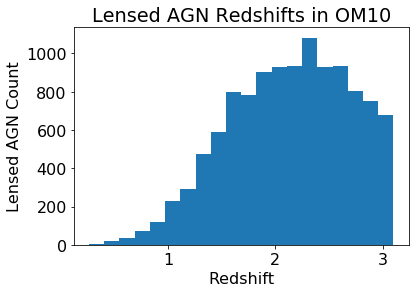

In [11]:
n_z, bins_z, _ = plt.hist(agn_cat['z_src'], bins=20, range=(binz_min, binz_max))
plt.xlabel('Redshift')
plt.ylabel('Lensed AGN Count')
plt.title('Lensed AGN Redshifts in OM10')

In [12]:
# The Minimum and Maximum Redshifts in the catalog
mag_i_min, mag_i_max = np.min(agn_cat['mag_i_src']), np.max(agn_cat['mag_i_src'])
print(mag_i_min, mag_i_max)

16.79 26.97


In [13]:
# Since we allow matching within 0.25 these are the min, max allowable AGN i-band mags in DC2 matching
bin_imag_min, bin_imag_max = mag_i_min-0.25, mag_i_max+.25
print(bin_imag_min, bin_imag_max)

16.54 27.22


Text(0.5, 1.0, 'Lensed AGN i-band mag in OM10')

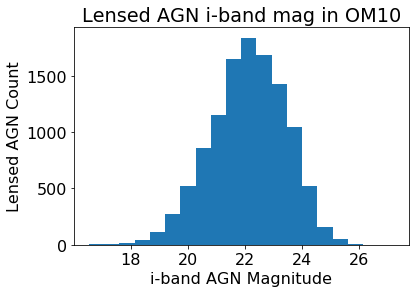

In [14]:
n_imag, bins_imag, _ = plt.hist(agn_cat['mag_i_src'], bins=20, range=(bin_imag_min, bin_imag_max))
plt.xlabel('i-band AGN Magnitude')
plt.ylabel('Lensed AGN Count')
plt.title('Lensed AGN i-band mag in OM10')

### Set up sampling functions

We will use these to set probabilities of choosing DC2 AGN that fall in these bins.

In [15]:
dens_z = copy(n_z)
dens_z = dens_z / np.max(dens_z)
dens_z[:8] += 0.1
dens_z[-8:] = 1.0
dens_z[:-8] -= 0.08
dens_z[5:-8] -= 0.05
dens_z[3] -= 0.01
dens_z[4] -= 0.03
dens_z[5] += 0.0
dens_z[6] -= 0.03
dens_z[7] -= 0.05
dens_z[8] -= 0.01
dens_z[9] -= 0.03
dens_z[10] += 0.04
dens_z[11] -= 0.02

Text(0.5, 1.0, 'Probability of choosing DC2 galaxy in Sprinkler')

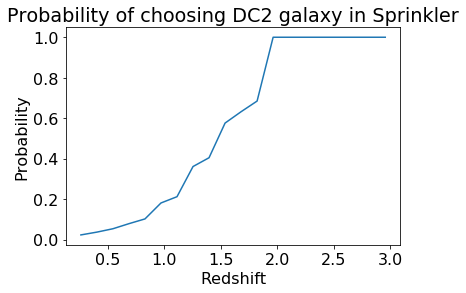

In [16]:
plt.plot(bins_z[:-1], dens_z)
plt.xlabel('Redshift')
plt.ylabel('Probability')
plt.title('Probability of choosing DC2 galaxy in Sprinkler')

In [17]:
np.savetxt('../data/agn_z_density.dat', dens_z)

In [18]:
dens_imag = copy(n_imag)
dens_imag = dens_imag / np.max(dens_imag)
dens_imag[2:-6] += 2. * dens_imag[8:]
dens_imag[9] += 0.1
dens_imag[10] += 0.2
dens_imag[11] += 0.1
dens_imag[6:15] += 1. * (1. - np.linspace(0, 1, 9))
dens_imag = dens_imag / np.max(dens_imag)
dens_imag[2:4] += .2
dens_imag[4:10] = 1.0
dens_imag[10:-7] = 1.0
dens_imag[11] = 0.8
dens_imag[12] = 0.6
dens_imag[-7:] *= 0.5

In [19]:
bins_imag

array([16.54 , 17.074, 17.608, 18.142, 18.676, 19.21 , 19.744, 20.278,
       20.812, 21.346, 21.88 , 22.414, 22.948, 23.482, 24.016, 24.55 ,
       25.084, 25.618, 26.152, 26.686, 27.22 ])

Text(0.5, 1.0, 'Probability of choosing DC2 galaxy in Sprinkler')

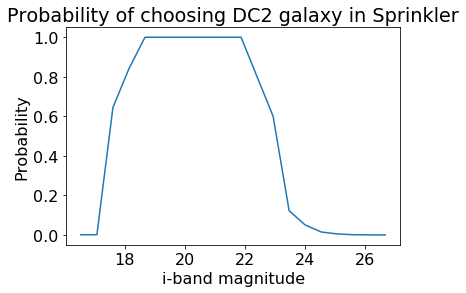

In [20]:
plt.plot(bins_imag[:-1], dens_imag)
plt.xlabel('i-band magnitude')
plt.ylabel('Probability')
plt.title('Probability of choosing DC2 galaxy in Sprinkler')

In [21]:
bins_imag

array([16.54 , 17.074, 17.608, 18.142, 18.676, 19.21 , 19.744, 20.278,
       20.812, 21.346, 21.88 , 22.414, 22.948, 23.482, 24.016, 24.55 ,
       25.084, 25.618, 26.152, 26.686, 27.22 ])

In [22]:
np.savetxt('../data/agn_imag_density.dat', dens_imag)

We save these sampling functions to file and then use them in the sprinkler code. In the sprinkler we multiply the redshift probability times the magnitude probability and multiply by a scaling value which is currently 1.0 and calibrates the overall number of systems.

### Test out the sampling by running the sprinkler

In [23]:
agn_hosts, agn_sys_cat = dc2_sp.sprinkle_agn()

In [24]:
agn_hosts.head()

,galaxy_id,ra,dec,redshift,gamma_1,gamma_2,kappa,av_internal_disk,av_internal_bulge,rv_internal_disk,...,magnorm_disk,magnorm_bulge,fluxes_disk,fluxes_bulge,sed_disk,sed_bulge,gal_type,magnorm_agn,mag_i_agn,varParamStr_agn
17008,1875299621,52.862247,-27.840443,0.451181,-0.002175,0.005562,-0.001001,0.3,0.3,4.0,...,"[23.50112622791565, 23.4735370046433, 23.50799...","[19.753732470638646, 19.540521508042076, 19.34...","[7.204981294214914e-07, 7.418789880237264e-07,...","[3.8264775097187525e-06, 1.0557723563723791e-0...",b'galaxySED/Const.20E08.02Z.spec.gz',b'galaxySED/Exp.50E09.0005Z.spec.gz',kinney-elliptical,20.348565,20.128153,"{""m"": ""applyAgn"", ""p"": {""seed"": 4020051, ""agn_..."
56777,1876005576,52.613531,-27.839463,0.714599,0.012985,0.003445,0.006585,0.4,0.1,4.0,...,"[26.04044412714207, 26.017461035576797, 25.965...","[20.770294283748356, 20.788668896055004, 20.73...","[9.440789901912083e-08, 9.523522186262107e-08,...","[3.6576707029982863e-06, 4.03266132491379e-06,...",b'galaxySED/Burst.19E07.02Z.spec.gz',b'galaxySED/Exp.25E09.1Z.spec.gz',kinney-elliptical,21.829105,21.654666,"{""m"": ""applyAgn"", ""p"": {""seed"": 8022933, ""agn_..."
85353,1876519708,52.898971,-27.588704,0.845949,-0.011171,-0.005203,-0.005566,0.4,0.1,4.0,...,"[24.875585684080118, 24.859651279658827, 24.87...","[20.381331560729873, 20.393758575187373, 20.29...","[2.730535738054766e-07, 2.546109572090378e-07,...","[5.686356815843988e-06, 5.965180347858453e-06,...",b'galaxySED/Const.40E07.02Z.spec.gz',b'galaxySED/Exp.20E09.1Z.spec.gz',kinney-elliptical,22.120220,21.942742,"{""m"": ""applyAgn"", ""p"": {""seed"": 1710039, ""agn_..."
95439,1876695857,52.546219,-28.042984,0.883605,-0.002330,-0.023106,-0.010028,0.0,0.1,2.0,...,"[30.598316187904057, 30.645420538137145, 30.66...","[21.8910985670889, 21.886933398597794, 21.8857...","[3.880622636671241e-09, 3.053683454418982e-09,...","[1.441811456789912e-06, 1.4922529463386161e-06...",b'galaxySED/Inst.15E07.002Z.spec.gz',b'galaxySED/Exp.20E09.1Z.spec.gz',kinney-elliptical,22.225172,22.039325,"{""m"": ""applyAgn"", ""p"": {""seed"": 4636896, ""agn_..."
97040,1876724326,52.583562,-28.084166,0.882389,0.001468,-0.013728,-0.008336,0.8,0.1,4.0,...,"[26.40761685235798, 26.400052560210433, 26.377...","[20.621939401794283, 20.6649259521617, 20.7291...","[3.0040031555325073e-08, 2.9218554445727618e-0...","[3.85996747678299e-06, 3.7930136885170256e-06,...",b'galaxySED/Exp.50E07.02Z.spec.gz',b'galaxySED/Exp.25E09.04Z.spec.gz',kinney-elliptical,23.405445,23.219719,"{""m"": ""applyAgn"", ""p"": {""seed"": 4653944, ""agn_..."


In [26]:
len(agn_hosts)

1476

Text(0.5, 1.0, 'Comparing Matched Redshifts to OM10')

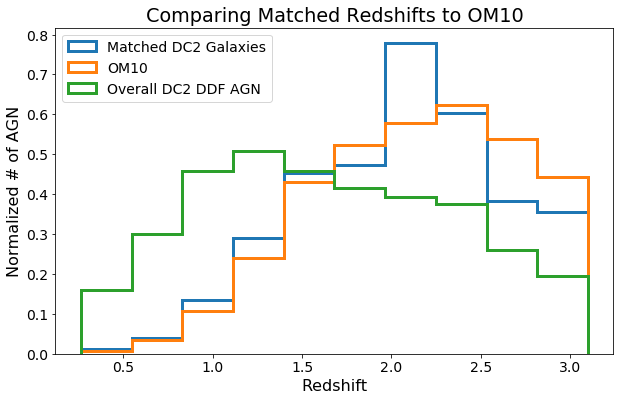

In [27]:
fig = plt.figure(figsize=(10,6))
n, bins, _ = plt.hist(agn_hosts['redshift'], density=True, histtype='step',
                      label='Matched DC2 Galaxies', lw=3, bins=10, range=(binz_min, binz_max))
plt.hist(agn_cat.query('z_src <= %f' % binz_max)['z_src'], density=True,
         histtype='step', label='OM10', lw=3, bins=bins)
plt.hist(dc2_sp.gal_cat.query('magnorm_agn > -99')['redshift'], density=True,
         histtype='step', bins=bins, label='Overall DC2 DDF AGN', lw=3)
plt.xlabel('Redshift', size=16)
plt.ylabel('Normalized # of AGN', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14, loc=2)
plt.title('Comparing Matched Redshifts to OM10')

Text(0.5, 1.0, 'Comparing Matched i-band magnitudes to OM10')

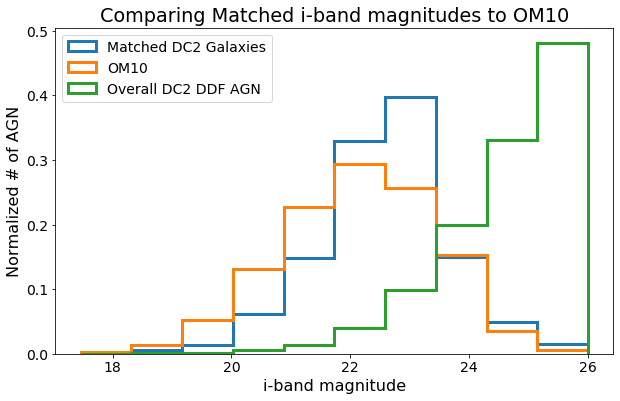

In [28]:
fig = plt.figure(figsize=(10,6))
n, bins, _ = plt.hist(agn_hosts['mag_i_agn'], density=True, histtype='step',
                      label='Matched DC2 Galaxies', lw=3, bins=10)
plt.hist(agn_cat.query('z_src <= %f' % binz_max)['mag_i_src'], density=True,
         histtype='step', label='OM10', lw=3, bins=bins)
plt.hist(dc2_sp.gal_cat.query('magnorm_agn > -99')['mag_i_agn'], density=True,
         histtype='step', bins=bins, label='Overall DC2 DDF AGN', lw=3)
plt.xlabel('i-band magnitude', size=16)
plt.ylabel('Normalized # of AGN', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14, loc=2)
plt.title('Comparing Matched i-band magnitudes to OM10')

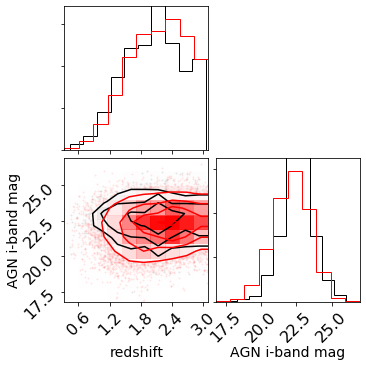

In [29]:

fig = corner.corner(agn_hosts[['redshift', 'mag_i_agn']].values, bins=10, hist_kwargs={'density':True},
                    labels=['redshift', 'AGN i-band mag'], label_kwargs={'size':14})
corner.corner(agn_cat.query('z_src <= %f' % binz_max)[['z_src', 'mag_i_src']].values,
              bins=10, color='r', fig=fig, hist_kwargs={'density':True})
plt.show()

Our redshift distribution looks close but we have some trouble with i-band magnitudes since the OM10 population is brighter than is actually possible with the DC2 population. It looks like it's about as well as we can do with what we have and yields 1476 systems which is a good sample size.

## Define new sprinkler with a new SNe density function

We want to calibrate probabilities of choosing DC2 SNe hosts to be sprinkled. To calibrate these probabilities we will try to match aspects of the overall SNe and SNe host population with our sprinkled population.

### Review of matching code currently in Sprinkler

#### The function `assign_matches_sne` works in the sprinkler to match potential host galaxies to sprinkled systems

It first calculates a probability for a galaxy to host a SN with the function `sne_density` based upon stellar mass and galaxy type. Then it draws from a value from a uniform distribution to see if that galaxy gets a SN. If it does then it moves on to `find_possible_match_sne` to find the lensed SN systems that match up to this galaxy based upon redshift and galaxy type.

```
    def assign_matches_sne(self, sne_gals, rand_state):
        
        sprinkled_sne_gal_rows = []
        sprinkled_gl_sne_cat_rows = []

        for i in range(len(sne_gals)):
            
            if i % 10000 == 0:
                print(i)
            
            # Draw probability that galaxy is sprinkled
            sne_density = self.sne_density(sne_gals.iloc[i])

            density_draw = rand_state.uniform()
            if density_draw > sne_density: 
                continue
            
            sne_cat_idx = self.find_possible_match_sne(sne_gals.iloc[i])
                
            sne_idx_keep = [x for x in sne_cat_idx
                            if x not in sprinkled_gl_sne_cat_rows]

            if len(sne_idx_keep) == 0:
                continue   
            
            sprinkled_gl_sne_cat_rows.append(
                rand_state.choice(sne_idx_keep))
            sprinkled_sne_gal_rows.append(i)
            
        return sprinkled_sne_gal_rows, sprinkled_gl_sne_cat_rows
```

#### `sne_density` determines the probability of a galaxy hosting a SN

We use the galaxy types we determined when creating the catalog and the stellar mass of the galaxy to get probabilities that conform with the rates in Table 2 of [Mannucci et al. 2005](https://www.aanda.org/articles/aa/pdf/2005/15/aa1411.pdf).

We add in a normalization factor to get the approximate number of lensed SNe we want in the DDF field over the 10 years.

```
    def sne_density(self, sne_gal_row):
        
        density_norm = 0.05
        
        stellar_mass = sne_gal_row['stellar_mass']
        host_type = sne_gal_row['gal_type']
        
        if host_type == 'kinney-elliptical':
            density_host = 0.044 * stellar_mass * 1e-10
        elif host_type == 'kinney-sc':
            density_host = 0.17 * stellar_mass * 1e-10
        elif host_type == 'kinney-starburst':
            density_host = 0.77 * stellar_mass * 1e-10
        
        density_val = density_norm * density_host

        return density_val
```

#### `find_possible_match_sne` matches potential host galaxies with appropriate systems in the lensed SNe catalog

We find lensed SNe systems that are approximately the same in host mass redshift and type.

```
    def find_possible_match_sne(self, gal_cat):

        gal_z = gal_cat['redshift']
        gal_type = gal_cat['gal_type']

        # search the SNe catalog for all sources +- 0.05 dex in redshift
        # and with matching type
        lens_candidate_idx = []

        w = np.where((np.abs(np.log10(self.gl_sne_cat['z_src']) -
                             np.log10(gal_z)) <= 0.05) &
                     (self.gl_sne_cat['type_host'] == gal_type))
        lens_candidate_idx = w[0]    

        return lens_candidate_idx
```

In [30]:
# Load Goldstein et al. catalog
sne_cat = dc2_sp.gl_sne_cat

### Test out the sampling by running the sprinkler

In [32]:
#dc2_sp.gal_cat = dc2_sp.gal_cat.iloc[:10000]

In [33]:
len(dc2_sp.gl_sne_cat)

176241

In [34]:
sne_hosts, sne_sys_cat = dc2_sp.sprinkle_sne()

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000


In [35]:
sne_hosts.head()

,galaxy_id,ra,dec,redshift,gamma_1,gamma_2,kappa,av_internal_disk,av_internal_bulge,rv_internal_disk,...,magnorm_disk,magnorm_bulge,fluxes_disk,fluxes_bulge,sed_disk,sed_bulge,gal_type,magnorm_agn,mag_i_agn,varParamStr_agn
807,1875015463,52.848254,-27.656528,0.161107,-0.001926,-0.002765,-0.000353,0.4,0.0,4.0,...,"[21.264243708472424, 21.21184698864384, 21.253...","[18.39474452631916, 18.332377922406284, 18.280...","[5.523403383558069e-07, 3.4108316519740194e-06...","[1.691775942608243e-05, 8.17149177966597e-05, ...",b'galaxySED/Burst.12E10.1Z.spec.gz',b'galaxySED/Inst.12E10.04Z.spec.gz',kinney-elliptical,23.194109,22.780837,"{""m"": ""applyAgn"", ""p"": {""seed"": 8585240, ""agn_..."
2310,1875044549,52.636912,-27.952853,0.232278,0.000182,-0.003534,0.002612,0.2,0.0,2.2,...,"[45.234032555741436, 45.13781478679364, 45.179...","[18.12121354220593, 18.0478810682791, 17.98531...","[5.547850644516766e-16, 1.3743767227569443e-15...","[1.6059871570660333e-05, 8.031565817911704e-05...",b'galaxySED/Exp.25E09.1Z.spec.gz',b'galaxySED/Inst.80E09.04Z.spec.gz',kinney-elliptical,22.100720,21.696990,"{""m"": ""applyAgn"", ""p"": {""seed"": 4660582, ""agn_..."
6111,1875113428,52.969748,-27.554475,0.314404,0.000882,0.000622,-0.001166,0.7,0.4,4.0,...,"[23.218549699742805, 23.119788458788083, 23.11...","[21.310456293676697, 21.206160632920568, 21.06...","[1.3502564383216043e-07, 3.2700753280537487e-0...","[3.9628120406158345e-07, 2.217190560777584e-06...",b'galaxySED/Exp.32E09.25Z.spec.gz',b'galaxySED/Inst.50E09.02Z.spec.gz',kinney-sc,NaN,NaN,NaN
8171,1875148199,52.930183,-27.705258,0.335679,-0.002427,0.003057,-0.002353,0.0,0.2,2.0,...,"[24.80787565925327, 24.57545315739067, 24.5194...","[25.03424061244987, 25.311798859402007, 25.398...","[7.827959358924603e-08, 2.18835720149617e-07, ...","[1.5293963628223696e-08, 6.136448332578592e-08...",b'galaxySED/Inst.25E09.0005Z.spec.gz',b'galaxySED/Burst.16E09.1Z.spec.gz',kinney-sc,NaN,NaN,NaN
13913,1875247586,52.551354,-27.871693,0.432056,0.006396,-0.001115,-0.004375,0.4,0.2,4.0,...,"[20.606678998285076, 20.606771199664756, 20.66...","[22.179318442016804, 22.022283706315005, 21.88...","[4.376219400652158e-06, 5.7906585334705214e-06...","[1.0905511615448431e-07, 8.40338896637698e-07,...",b'galaxySED/Const.25E09.02Z.spec.gz',b'galaxySED/Burst.62E09.02Z.spec.gz',kinney-sc,22.955228,22.749889,"{""m"": ""applyAgn"", ""p"": {""seed"": 7672592, ""agn_..."


In [36]:
len(sne_hosts)

1388

### Look at some properties of the matched host galaxies and SNe

Text(0, 0.5, 'Galaxy Counts')

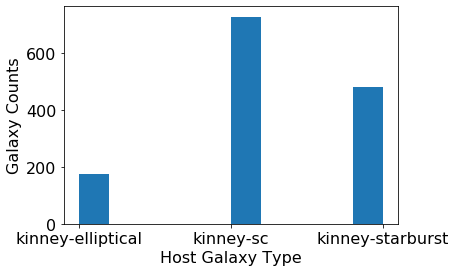

In [37]:
plt.hist(sne_hosts['gal_type'])
plt.xlabel('Host Galaxy Type')
plt.ylabel('Galaxy Counts')

Text(0, 0.5, 'Galaxy Counts')

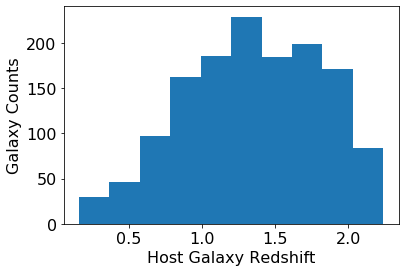

In [38]:
plt.hist(sne_hosts['redshift'])
plt.xlabel('Host Galaxy Redshift')
plt.ylabel('Galaxy Counts')

Text(0, 0.5, 'Count')

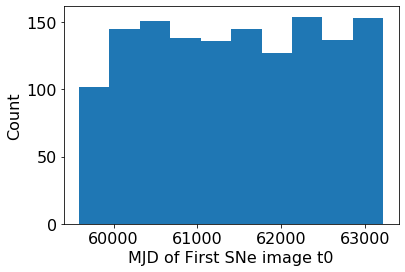

In [39]:
# Check distribution of times SNe appears
plt.hist(sne_sys_cat['t0'])
plt.xlabel('MJD of First SNe image t0')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

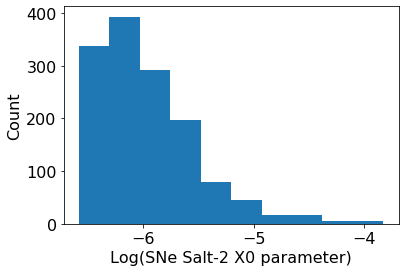

In [47]:
# Check distribution of times SNe appears
plt.hist(np.log10(sne_sys_cat['x0']))
plt.xlabel('Log(SNe Salt-2 X0 parameter)')
plt.ylabel('Count')